# Analise de ações com algoritmos de forecast

### instalando as dependecias

In [58]:
!pip install yfinance
!pip install fbprophet

## Importa dependecias

In [59]:
import pandas as pd
import yfinance as yf
import datetime 
import numpy as np
from datetime import timedelta
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import warnings
warnings.filterwarnings('ignore')



## Seleciona o código da ação e periodo

In [60]:
acao = 'ARZZ3.SA'
data_inicial = datetime.datetime.now().date() + datetime.timedelta(days=-4000)
data_final = datetime.datetime.now().date() 

## Faz o download do dataframe com as informações

In [61]:
df_acao_historico = yf.download(acao,data_inicial,data_final)

[*********************100%***********************]  1 of 1 completed


In [62]:
df_acao_historico

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-02-02,20.500000,22.000000,20.260000,21.250000,16.871756,14606400
2011-02-03,21.100000,21.100000,20.620001,21.049999,16.712965,1766100
2011-02-04,20.990000,21.280001,20.900000,21.000000,16.673267,873400
2011-02-07,21.000000,21.440001,20.900000,21.000000,16.673267,396100
2011-02-08,20.719999,21.100000,20.080000,20.080000,15.942820,3933
...,...,...,...,...,...,...
2021-11-29,69.970001,70.000000,67.870003,68.199997,68.199997,1033000
2021-11-30,68.360001,69.129997,64.830002,67.160004,67.160004,1402700
2021-12-01,68.120003,73.199997,67.940002,68.720001,68.720001,2045400


In [63]:
df_acao_historico.reset_index(inplace=True)

## Analise do dataframe

In [64]:
df_acao_historico.describe


<bound method NDFrame.describe of            Date       Open       High  ...      Close  Adj Close    Volume
0    2011-02-02  20.500000  22.000000  ...  21.250000  16.871756  14606400
1    2011-02-03  21.100000  21.100000  ...  21.049999  16.712965   1766100
2    2011-02-04  20.990000  21.280001  ...  21.000000  16.673267    873400
3    2011-02-07  21.000000  21.440001  ...  21.000000  16.673267    396100
4    2011-02-08  20.719999  21.100000  ...  20.080000  15.942820      3933
...         ...        ...        ...  ...        ...        ...       ...
2684 2021-11-29  69.970001  70.000000  ...  68.199997  68.199997   1033000
2685 2021-11-30  68.360001  69.129997  ...  67.160004  67.160004   1402700
2686 2021-12-01  68.120003  73.199997  ...  68.720001  68.720001   2045400
2687 2021-12-02  69.500000  72.930000  ...  72.300003  72.300003   1820100
2688 2021-12-03  72.160004  75.889999  ...  74.180000  74.180000   1350300

[2689 rows x 7 columns]>

In [65]:
df_acao_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2689 non-null   datetime64[ns]
 1   Open       2689 non-null   float64       
 2   High       2689 non-null   float64       
 3   Low        2689 non-null   float64       
 4   Close      2689 non-null   float64       
 5   Adj Close  2689 non-null   float64       
 6   Volume     2689 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 147.2 KB


## Ajuste tipo da Data

In [66]:
df_acao_historico.Date = pd.to_datetime(df_acao_historico.Date)
df_acao_historico = df_acao_historico.set_index(df_acao_historico['Date']).sort_index()
df_acao_historico.drop("Date", axis=1, inplace=True)

## Visualiza gráfico

In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_acao_historico.index, y=df_acao_historico['Close']))


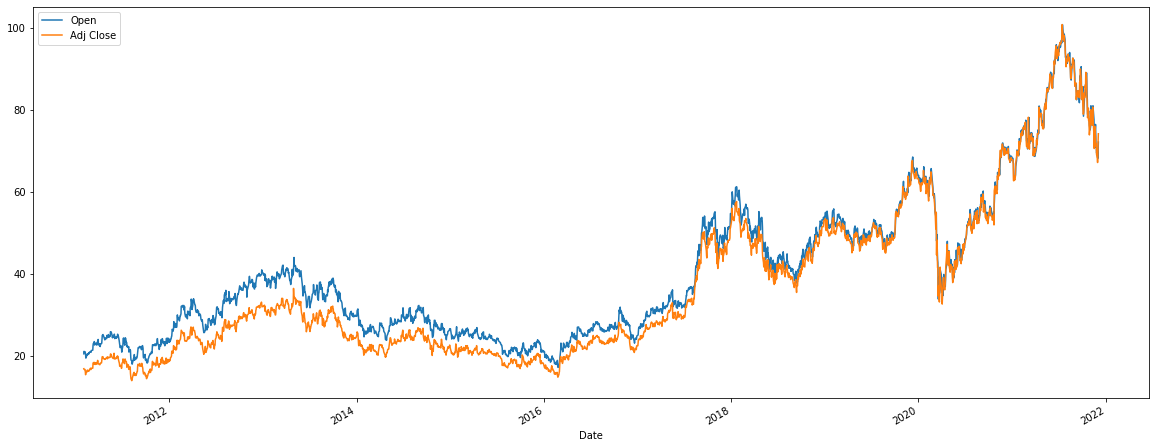

In [68]:
grafico_acao = df_acao_historico[['Open','Adj Close']]
grafico_acao.plot(figsize=(20,8))

## Media Móvel

In [69]:
df_ticket['MediaMovel10Dias'] = df_ticket["Adj Close"].rolling(window=10).mean()
df_ticket['MediaMovel30Dias'] = df_ticket["Adj Close"].rolling(window=30).mean()
df_ticket['MediaMovel150Dias'] = df_ticket["Adj Close"].rolling(window=150).mean()
df_ticket['MediaMovel365Dias'] = df_ticket["Adj Close"].rolling(window=365).mean()

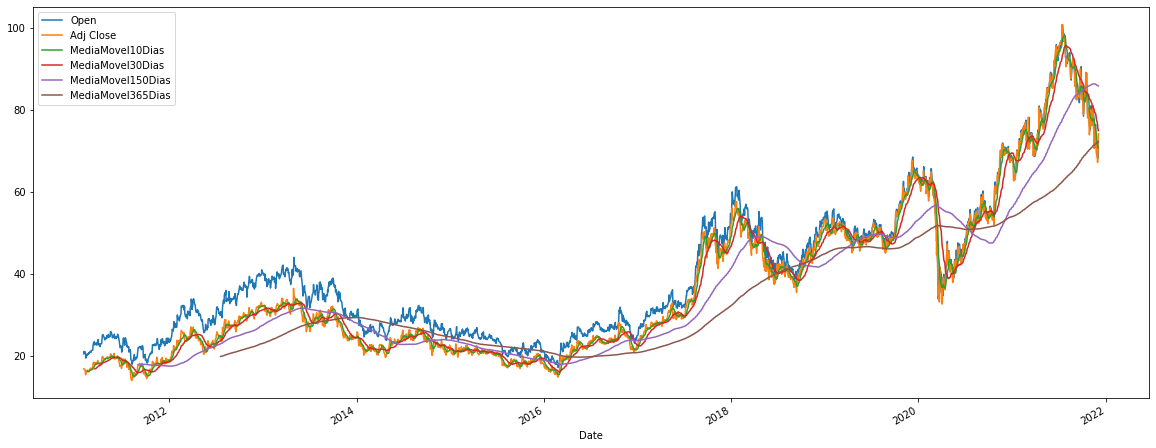

In [70]:
ts = df_ticket[['Open','Adj Close','MediaMovel10Dias','MediaMovel30Dias','MediaMovel150Dias','MediaMovel365Dias']]

ts.plot(figsize=(20,8))

# Forecast

## Prophet 

https://facebook.github.io/prophet/docs/quick_start.html

### configura a base de treino do modelo

In [86]:
# Base de treino

# Data de inicio do treino
dt_inicio_treino = "2011-04-01"
dt_fim_treino = "2021-12-03"

# Data para teste do modelo
dt_inicio_teste = "2019-06-01"
dt_fim_teste = "2021-12-03"

df_base_treino = df_acao_historico[dt_inicio_treino : dt_fim_treino]
df_base_testes = df_acao_historico[dt_inicio_teste : dt_fim_teste]

print('Train Dataset:',df_base_treino.shape)
print('Test Dataset:',df_base_testes.shape)



Train Dataset: (2649, 6)
Test Dataset: (622, 6)


In [87]:
#Transformando o Dataframe de teste correto para o Prophet
#Precisamos que a data volte a ser uma coluna
df_base_testes = df_base_testes.reset_index() 

#Excluindo as colunas que não vamos precisar
df_base_testes.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True) 

#Renomeando as colunas para o padrão do prophet
df_base_testes.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True) 
df_base_testes.head()

,ds,y
0,2019-06-03,50.139999
1,2019-06-04,48.500000
2,2019-06-05,49.200001
3,2019-06-06,49.000000
4,2019-06-07,49.599998


### executo script de treino do modelo

In [88]:
#Transformando o dataset de treinamento correto para o Prophet

df_base_treino = df_base_treino.reset_index()

df_base_treino.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True)

df_base_treino.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

df_base_treino.head()

,ds,y
0,2011-04-01,22.75
1,2011-04-04,22.49
2,2011-04-05,22.49
3,2011-04-06,22.50
4,2011-04-07,22.75


### Aplica o modelo

In [89]:
model = Prophet(growth ="linear",
                seasonality_mode = 'multiplicative',
                daily_seasonality = False)
model.fit(df_base_treino)

In [90]:
# determinar o período de dias para previsão
future_prices = model.make_future_dataframe(periods=365)

#Excluindo os finais de semana da  predição
future = future_prices[future_prices['ds'].dt.dayofweek < 5]

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

No Dataframe resultante da predição do Modelo do Prohet há 4 colunas, além da Data, são elas:

yhat = valor predito

yhat_lower = Menor valor predito

yhat_upper = Maior valor predito

e sem mais delongas, vamos visualizar o gráfico da previsão.

### Analise do resultado

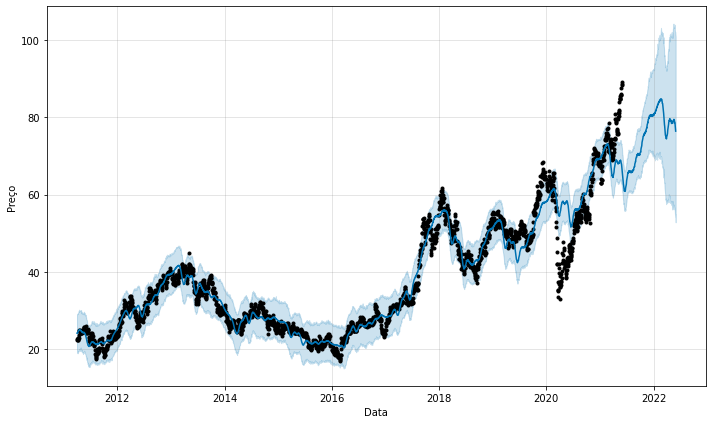

In [77]:
# É possivel plotar um grafico direto da biblioteca prophet
model.plot(forecast, xlabel='Data', ylabel='Preço');

In [91]:
plot_plotly(model,forecast)

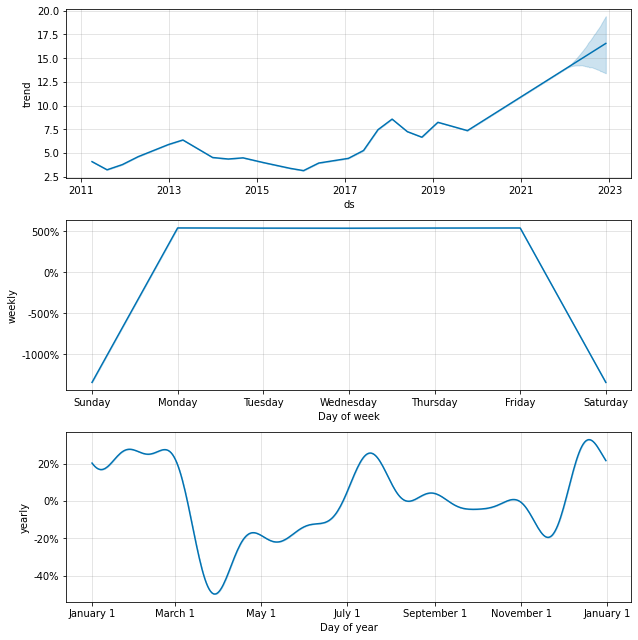

In [92]:
# separar os componentes do modelo
model.plot_components(forecast);

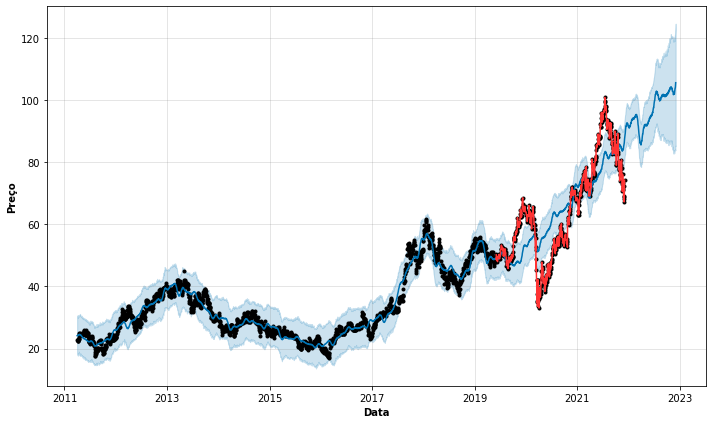

In [93]:
model.plot(forecast)
plt.plot(df_base_testes['ds'],df_base_testes['y'],'-',color='#ff3333',alpha=1)
plt.xlabel('Data',fontsize=10,fontweight='bold',color='black')
plt.ylabel('Preço',fontsize=10,fontweight='bold',color='black')
plt.show()

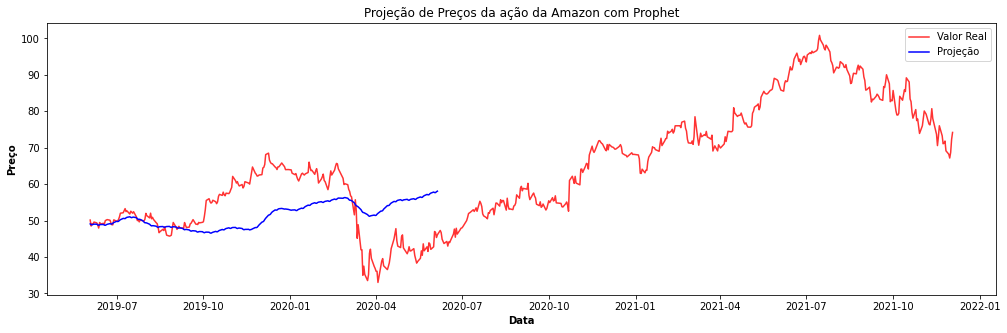

In [94]:
#Separando os dados para o periodo projetado
pred = forecast.set_index(forecast['ds']).sort_index()
pred.drop("ds", axis=1, inplace=True)
pred = pred[['yhat']]
pred = pred["2019-06-01" : "2020-06-05"]
pred = pred.reset_index()
pred.tail()

#Construindo o Grafico
plt.figure(figsize = (17,5))
plt.plot(df_base_testes['ds'],df_base_testes['y'],'-',color='#ff3333',alpha=1, label = "Valor Real")
plt.plot(pred['ds'],pred['yhat'],'-',color='b',alpha=1, label = "Projeção")
plt.xlabel('Data',fontsize=10,fontweight='bold',color='black')
plt.ylabel('Preço',fontsize=10,fontweight='bold',color='black')
plt.legend()
plt.title("Projeção de Preços da ação da Amazon com Prophet")
plt.show()

In [95]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, period='30 days', horizon = '180 days')

INFO:fbprophet:Making 106 forecasts with cutoffs between 2012-10-21 00:00:00 and 2021-06-06 00:00:00


  0%|          | 0/106 [00:00<?, ?it/s]

In [96]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,53.202555,7.294008,4.652465,0.103187,0.074843,0.375503
1,20 days,54.661525,7.393343,4.738586,0.105575,0.076915,0.365436
2,21 days,56.197560,7.496503,4.820609,0.107812,0.079973,0.361283
3,22 days,57.650139,7.592769,4.909071,0.110102,0.082464,0.348765
4,23 days,58.885084,7.673662,4.978450,0.111739,0.084775,0.344157


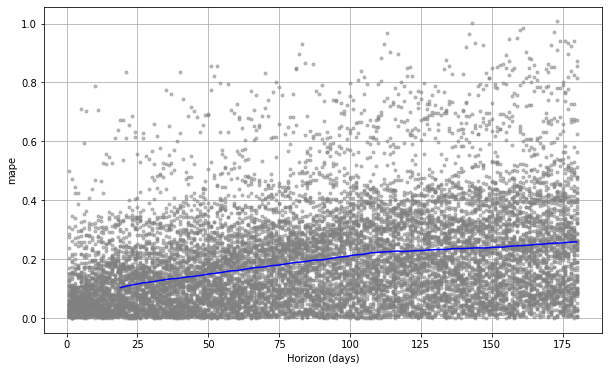

In [97]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Average forecasting

O average forecasting assume que os dados estão distribuídos em torno de uma média constante.
Rigorosamente, esse tipo de série temporal é chamada estacionária.

https://www.letscode.com.br/blog/python-para-financas-analise-de-series-temporais

### 

In [ ]:
def treino_teste(dados):

    # Definir quantos porcento queremos pra treino
    pct_treino = 0.75


    # Definir o primeiro dia, o último e o total de dias nos nossos dados
    primeiro_dia = min(dados.index)
    ultimo_dia = max(dados.index)
    total_dias = (ultimo_dia - primeiro_dia).days

    
    # "Dias de treino, dias de glória" - Charlie Brown Jr
    dias_treino = np.ceil(total_dias * pct_treino)
    dias_teste = np.floor(total_dias * (1 - pct_treino))

    # Data em que o treino deve parar
    data_parada = primeiro_dia + timedelta(days=dias_treino)
    

    # Dividir o dataset usando a data de parada do treino
    dados_treino = dados[:data_parada] # do começo à data de parada
    dados_teste = dados[data_parada:] # da data de parada ao final

    return dados_treino, dados_teste, data_parada

In [ ]:
def AF(X, y):
    # Criando lista com as médias
    y_hat_AF = []

    for i in range(len(y)):
        y_hat_AF.append(np.mean(X))

    # Transformando em Pandas Series
    y_hat_AF = pd.Series(y_hat_AF, index=y.index)
    
    return y_hat_AF

In [ ]:
X_ticket, y_ticket, data_parada_ticket = treino_teste(df_ticket['Close'])    

In [ ]:
y_hat_AF_ticket = AF(X_ticket, y_ticket)
df_average_forecasting = y_hat_AF_ticket

In [ ]:
# Gerando gráfico com fundo escuro

with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 5.5))
    plt.title("Average Forecast")
  
    # Dados reais
    plt.plot(X_ticket, label='Valores de treino')
    plt.plot(y_ticket,label='Valores reais')

    

    # Predições
    plt.plot(y_hat_AF_ticket, label='Average forecasting', color='red')
    plt.legend()
    plt.show()

## Drift forecast

O drift forecast assume que os dados estão distribuídos em torno de uma média constante que aumenta ou diminui constantemente no tempo.

Rigorosamente, esse tipo de série temporal é dito com drift.

In [ ]:
def DF(X, y):
    y_t = X[-1]
    m = (y_t - X[0]) / len(X)
    h = np.linspace(0,len(y.index)-1, len(y.index))

    # Criando lista com o resultado da fórmula
    y_hat_DF = []
    
    for i in range(len(y.index)):
        y_hat_DF.append(y_t + m * h[i])

    # Transformando em Pandas Series
    y_hat_DF = pd.Series(y_hat_DF, index=y.index)

    return y_hat_DF

In [ ]:
X_drift_ticket, y_drift_ticket, data_parada_drift_ticket = treino_teste(df_ticket['Close'])

In [ ]:
# Prevendo dados futuros com a função
y_hat_AF__drift_ticket = AF(X_drift_ticket, y_drift_ticket)

In [ ]:
# Prevendo dados futuros com a função
y_hat_DF_drift_ticket = DF(X_drift_ticket, y_drift_ticket)

In [ ]:
# Gerando gráfico com fundo escuro

with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 5.5))
    plt.title("Average Forecast")

    # Dados reais
    plt.plot(X_drift_ticket, label='Valores de treino')
    plt.plot(y_drift_ticket, label='Valores reais')

    # Predições
    plt.plot(y_hat_DF_drift_ticket, label='Average Forecast', color='red')
    plt.plot(y_hat_DF_drift_ticket, label='Drift Forecast', color='Yellow')

    plt.legend()
    plt.show()

## Simple moving average

O simple moving average acompanha as médias se movendo ao longo do tempo.

In [ ]:
def SMA(dados, day):
    y_hat_SMA = dados['Close'].rolling(window=day).mean()

    return y_hat_SMA

In [ ]:
days = [5, 10, 25, 50]
colors = ['green', 'blue', 'pink', 'purple']

# Gerando gráfico com fundo escuro 
with plt.style.context('dark_background'):
    # Configurações básicas
    plt.figure(figsize=(20, 5.5))
    plt.title("Simple Moving Average")

    # Dados reais
    plt.plot(X_ticket, label='Train values', color='white')
    plt.plot(y_ticket, label='Real value')

    # Moving average
    for i, day in enumerate(days):
        y_hat_SMA_ticket = SMA(df_ticket, day)
        plt.plot(y_hat_SMA_ticket, label='Simple moving average '+str(day), color=colors[i])

    # Previsões anteriores        
    plt.plot(y_hat_AF_ticket, label='Average Forecast', color='red')
    plt.plot(y_hat_DF_drift_ticket, label='Drift Forecast', color='Yellow')


    # Configurações básicas
    plt.legend()
    plt.show()

## Cumulative moving average